In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 10

import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
# Load Electricity price data, 15 minute interval over two years: 2016 and 2017:
import zipfile
with zipfile.ZipFile("C:/Users/anutako/Dropbox/jm2017/data_incubator/Electricity_Prices/rpt.00013061.0000000000000000.20180101.082427782.RTMLZHBSPP_2017.zip") as z:
    with z.open("rpt.00013061.0000000000000000.RTMLZHBSPP_2017.xlsx") as f:
        dset_electr_pr2017 = pd.ExcelFile(f)
with zipfile.ZipFile("C:/Users/anutako/Dropbox/jm2017/data_incubator/Electricity_Prices/rpt.00013061.0000000000000000.20170101.083302375.RTMLZHBSPP_2016.zip") as z:
    with z.open("rpt.00013061.0000000000000000.RTMLZHBSPP_2016.xlsx") as f:
        dset_electr_pr2016 = pd.ExcelFile(f)

In [3]:
# Load Weather Temperature data, hourly, from 2012 till the end of November 2017:
with zipfile.ZipFile("C:/Users/anutako/Dropbox/jm2017/data_incubator/Weather_data/historical-hourly-weather-data.zip") as z:
    with z.open("temperature.csv") as f:
        dset_tempr = pd.read_csv(f, header=0, delimiter=",")

In [28]:
#Create one datasets for Electricity prices out of two
sh_names2016  = dset_electr_pr2016.sheet_names
sh_names_len = len(sh_names2016)
dset = pd.DataFrame([])
for i in range(sh_names_len):
    dset = dset.append(dset_electr_pr2016.parse(sh_names2016[i]))
sh_names2017  = dset_electr_pr2017.sheet_names
sh_names_len = len(sh_names2017)
for i in range(sh_names_len):
    dset = dset.append(dset_electr_pr2017.parse(sh_names2017[i]))
dset_shape = dset.shape;

In [30]:
# Data manipulation to create index for Electricity Price dataset
dset["Delivery Interval"] = dset["Delivery Interval"].replace([1, 2, 3, 4], [':00', ':15', ':30', ':45'])
dset["Delivery Hour"] = dset["Delivery Hour"].replace(range(1,25), range(24))
dset["Delivery Time"] = dset["Delivery Date"].astype('str') + ' ' +dset["Delivery Hour"].astype(str) + dset["Delivery Interval"]
dset["Delivery Time"] = pd.to_datetime(dset["Delivery Time"])
dset = dset.drop(columns = ["Delivery Date", "Delivery Hour", "Delivery Interval" ])
dset.set_index("Delivery Time" , inplace=True)

In [36]:
# Extract data for Houston Settlement Point
SPnames = dset["Settlement Point Name"].unique()
#print(SPnames)

dset_houston = dset[dset["Settlement Point Name"] == SPnames[1]]
#dset_houston.describe()

In [33]:
# Extract data for temperatures in Houston
dset_tempr.set_index("datetime" , inplace=True)
dset_tempr_hou = dset_tempr["Houston"]
dset_tempr_hou = dset_tempr_hou.rename('Temperature')

#Convert from Kelvin to Fahernheits:
dset_tempr_hou = 1.8*(dset_tempr_hou-273.15)+32

start_date = '2016-01-01 00:00:00'
end_date   = '2017-11-30 00:00:00'

dset_tempr_hou = dset_tempr_hou.loc[start_date:end_date]

dset_hourly_price = dset_houston["Settlement Point Price"].resample('H').mean()
dset_hourly_price = dset_hourly_price.loc[start_date:end_date]
dset_hourly_price = dset_hourly_price.rename("Price")

#Combine two Series into DataFrame
data = pd.concat([dset_hourly_price, dset_tempr_hou], axis=1)

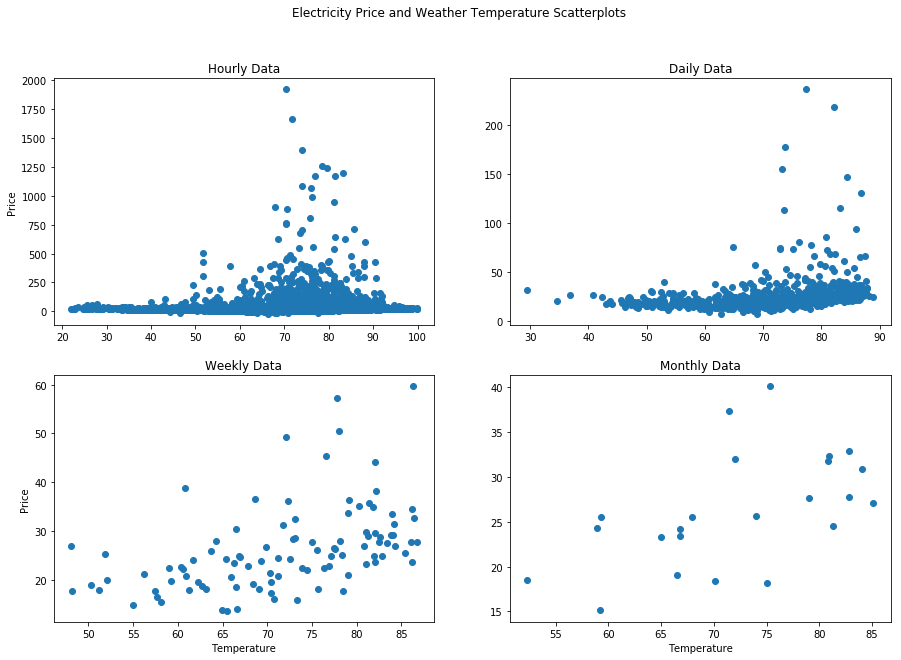

In [35]:
plt.rcParams['figure.figsize'] = 15, 10
fig = plt.figure()

plt.subplot(2,2,1)
plt.scatter(data['Temperature'],data['Price'])
plt.title('Hourly Data')
plt.ylabel('Price');

plt.subplot(2,2,2)
data_daily = data.resample('D').mean()
plt.scatter(data_daily['Temperature'], data_daily['Price'])
plt.title('Daily Data')

plt.subplot(2,2,3)
data_weekly = data.resample('W').mean()
plt.scatter(data_weekly['Temperature'], data_weekly['Price'])
plt.title('Weekly Data')
plt.xlabel('Temperature')
plt.ylabel('Price')

plt.subplot(2,2,4)
data_monthly = data.resample('M').mean()
plt.scatter(data_monthly['Temperature'], data_monthly['Price'])
plt.title('Monthly Data')
plt.xlabel('Temperature')

fig.suptitle('Electricity Price and Weather Temperature Scatterplots');